https://github.com/renatofillinich/ab_test_guide_in_python/blob/master/AB%20testing%20with%20Python.ipynb

https://www.kaggle.com/code/ouzcanmaden/a-b-testing#B.-Case-Study---II

# Background

A product team in an online e-commerce business is working on a new version of the company's webpage with the hope that it will lead to a higher conversion rate. Each user's interaction is tracked, and a binary `converted` indicates whether the user click on the webpage or not.

The team was told that the current conversion rate is 12% on average, and the company would be happy with an increase of 2% - that is, the new product can be considered a success if it can raise the conversion rate to 14%.

Conversion rate: the proportion of users who complete an action, in this case clicking on the webpage, among the total number of users visiting the webpage.

# Approach

The team will conduct an A/B testing, performing a two-sample z-test for the difference between proportions. The team will compare the conversion between the treatment group (new page design) and the control group (old page design).

# Business questions
- Which page design resulted in a higher conversion rate during the A/B test?
- Is the difference in conversion rate between the two page deisng statistically significant or due to chance?

# Setting up the experiment

## Formulating the hypothesis
Since the team doesn't know if the new page design will perform better or worse than the current design, the team will choose a **two-tailed test**:<center>
$H_{0}: p_1 = p_2$ <br>
$H_{a}: p_1 \ne p_2$
</center>

where $p_1$ and $p_2$ are the conversion rate of the new and old page design respectively. The team also sets the **confidence level** of 95%, so the level of significance is:
<center>$\alpha=0.05$</center>

Recall: $\alpha$ is the probablity of rejecting the null hypothesis given that the null hypothesis is true. (Probability of commiting Type I error)

## Choosing sample size
The team will not test the whole user base (population) because it would be very expensive. The conversion rate, therefore, will be just an estimate of the true rate.

The number of users captured in each group, control and treatment group, will impact the precision of the estimated conversion rate. The larger the sample size, the more precise the estimates, the higher the chance to detect a difference in the two group if it exists. However, collecting a large sample will cost the company a lot of money and time to complete the test though.
*
To find the effective sample size, the team can use a technique call **`Power Analysis`** which calulates the smallest sample size needed for an experiment, given a required level of significance, power of the test, and effect size.
- **Level of significance**: $\alpha$ = 0.05
- **Power of the test** (1 - $\beta$): the probability of finding a statistical difference betwen the two groups in the test when a difference actually exists ($\beta$: the probability of making Type II error). Usually set at 80% as default
- **Effect size**: the expected difference in conversion rate between the two groups, calculated by using the funtion **`proportion_effectsize`** in `statsmodels` package, defined as the following formula: $2 \times (arcsin(\sqrt{p_1}) - arcsin(\sqrt{p_2}))$

Since the company wants to increase the conversion rate from 12% to 14%, the team can use these values to calculate the desire effect size.

The class **`NormalIndPower`** and its method **`solve_power`** in `statsmodels` package can be used to calculate the sample size.

In [329]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

from math import ceil

In [365]:
# Set a confidence level
conf_lvl = 0.95 

# Level of significance                            
alpha = 1 - conf_lvl

# Calculate the effect size using proportions of 12% and 14%
effect_size = proportion_effectsize(0.12, 0.14)   

# Calculate the sample size and round up to the next number
sample_size = NormalIndPower().solve_power(effect_size, 
                               power=0.8,
                                alpha=alpha,
                               ratio=1)
sample_size = ceil(sample_size)
print(f"The smallest sample size needed for the experiment: {sample_size}")                               

The smallest sample size needed for the experiment: 4433


# Collecting the Data

Before performing a hypothesis testing, one should have a glance at the dataset, and clean it if needed.

In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [367]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [368]:
df.shape

(294478, 5)

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
# Timestamp
df['timestamp'] = df.timestamp.apply(pd.to_datetime)

In [391]:
df.describe(include='all')

C:\Users\hoang\AppData\Local\Temp/ipykernel_11704/2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,user_id,timestamp,group,landing_page,converted
count,294478.000000,294478,294478,294478,294478.000000
unique,NaN,294478,2,2,NaN
top,NaN,2017-01-21 22:11:48.556739,treatment,old_page,NaN
freq,NaN,1,147276,147239,NaN
first,NaN,2017-01-02 13:42:05.378582,NaN,NaN,NaN
last,NaN,2017-01-24 13:41:54.460509,NaN,NaN,NaN
mean,787974.124733,NaN,NaN,NaN,0.119659
std,91210.823776,NaN,NaN,NaN,0.324563
min,630000.000000,NaN,NaN,NaN,0.000000
25%,709032.250000,NaN,NaN,NaN,0.000000


In [392]:
# Unique values in each column
df.apply(pd.unique)

user_id         [851104, 804228, 661590, 853541, 864975, 93692...
timestamp       [2017-01-21T22:11:48.556739000, 2017-01-12T08:...
group                                        [control, treatment]
landing_page                                 [old_page, new_page]
converted                                                  [0, 1]
dtype: object

In [371]:
# Number of users in each group 
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


The dataset contains 294478 rows and 5 columns:
- `user_id`: the ID of each user
- `timestamp`: timestamp of each interaction
- `group`: the group that the user is assigned to
- `landing_page`: the design that the user saw in the interaction
- `converted`: wheter the user ended in a conversion or not

The cross table above shows that some users in the control group were shown the new page design, and some users in the treatment group were shown the old page design. The team needs to check if those users are present in both groups, if so, they need to be removed from the dataset because the test requires the samples to be independent.


In [372]:
df.duplicated(subset='user_id').sum()

3894

There are 3894 users who appear more than one time in the dataset.

Now, remove all records that contain those user IDs.

In [373]:
df_cleaned = df.drop_duplicates(subset='user_id', keep=False)

# Compute the number of users in each group again
pd.crosstab(df_cleaned.group, df_cleaned.landing_page)

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


Now the table shows that all users in the control groups only saw the old page design, and all users in the treatment group only saw the new page design.

The next step is to collect the samples.

In [470]:
# Setting the random seed
SEED = 42

# Randomly collect samples with the chosen random seed
sample_control = df_cleaned.loc[df_cleaned.group == 'control'].sample(sample_size, random_state=SEED)
sample_treatment = df_cleaned.loc[df_cleaned.group == 'treatment'].sample(sample_size, random_state=SEED)

# Concatenate both samples
ab_test = pd.concat([sample_control, sample_treatment], axis=0).reset_index(drop=True)

In [471]:
# Calculate the conversion rate, standard deviation, and standard error
conversion_rate = ab_test.groupby('group').converted.agg([np.mean, np.std, stats.sem])
conversion_rate.columns = ['conversion_rate', 'std_dev', 'std_error']
conversion_rate.style.format('{:.4f}')

,conversion_rate,std_dev,std_error
group,,,
control,0.1126,0.3161,0.0047
treatment,0.1270,0.3330,0.0050


- Conversion rate: represent the ratio between the number of users clicking on the webpage and the total number of users shown the webpage.
- The standard devitation: provide information about the spread of the conversion rate values around the mean.
- The standard error: measure the precision of the estimated mean conversion rate.

The stats above shows that there seems to be small difference in conversion rate between the two groups, with the treatment group performing slightly better, approximately 11.26% vs 12.70%.

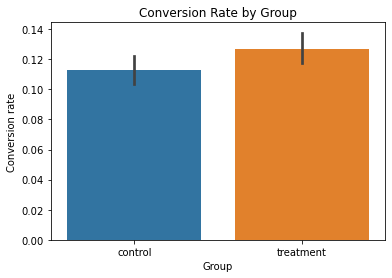

In [478]:
sns.barplot(data=ab_test, x='group', y='converted')
plt.xlabel("Group")
plt.ylabel("Conversion rate")
plt.title("Conversion Rate by Group")
plt.show()

To determine this difference is statistically significant or due to chance, the team will proceed to the last stage, testing the hypothesis

# Testing the hypothesis

In [482]:
# Extract the converted values in each group
control_converted = ab_test.query('group == "control"')['converted']
treatment_converted = ab_test.query('group == "treatment"')['converted']

# Calculate number of successes in each groups
n_successes = [control_converted.sum(), treatment_converted.sum()]
# Number of trials
n_trials = [len(control_converted), len(treatment_converted)]

# Compute the test statistics and p-value
z_stat, p_value = proportions_ztest(n_successes, n_trials )
(lower_con, upper_con,), (lower_treat, upper_treat) = proportion_confint(n_successes, n_trials, alpha=alpha)

print(f"z statistic: {z_stat:.4f}")
print(f'p-value: {p_value:.4f}')
print(f"95% confidence interval for control group: ({lower_con:.4f}, {upper_con:.4f})")
print(f"95% confidence interval for treatment group: ({lower_treat:.4f}, {upper_treat:.4f})")

z statistic: -2.0933
p-value: 0.0363
95% confidence interval for control group: (0.1033, 0.1172)
95% confidence interval for treatment group: (0.1219, 0.1368)


# Conclusion

Since the p-value = 0.0363 is less than $\alpha$ = 0.05, there is sufficient evidence to reject the null hypothesis. The team can conclude that there is a statistically significant difference in conversion rate between the two page designs. Furthermore, the stat shows that the new design resulted in higher click through rate.

# Appendix

In [483]:
# Manually calculate
p1 = control_converted.mean()
p2 = treatment_converted.mean()
n1 = n2 = sample_size
weighted_est = (p1 * n1 + p2 * n2) / (n1 + n2)

z_test = (p1 - p2) / np.sqrt(weighted_est*(1-weighted_est)*(1/n1 + 1/n2))
p_value = (1 - stats.norm.cdf(np.abs(z_test)))*2

print(f"Test statistics: {z_test}")
print(f"P-value: {p_value}")

Test statistics: -2.093258911271672
P-value: 0.036326048410088685
